In [10]:
# Predicting potential alliance shifts in a world war using graph balance theory
# Heron Ziegel
# 915986142

import pymnet
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [11]:
# Grab WW1 data to test with
df = pd.read_csv('../Data/WW1.csv')
print(df)

       Unnamed: 0  UK  France  Russia  Italy  Germany  AustriaHungary
0              UK   1       2       2      0        0               2
1          France   2       1       2      0        2               2
2          Russia   2       2       1      0        1               1
3           Italy   0       0       0      1        0               0
4         Germany   0       2       1      0        1               1
5  AustriaHungary   2       2       1      0        1               1


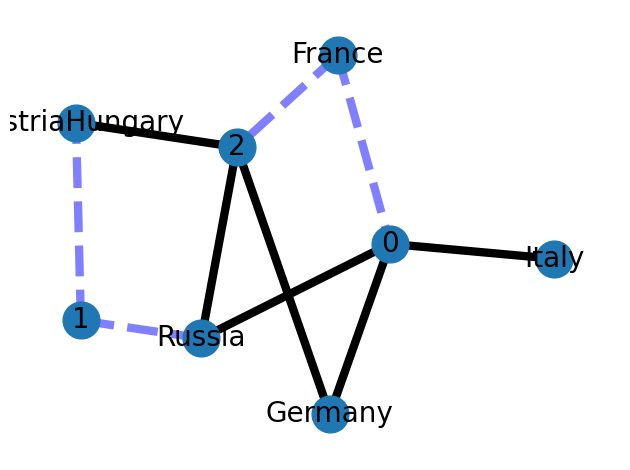

In [14]:
# Build and visualize initial graph
array = df.to_numpy()

G = nx.Graph()

# Iteratively build graph based on array
for i in range(1,6):
    for j in range(1,6):
        if i != j and array[i, j] != 0:
            G.add_edge(array[i,0], array[0,j], weight=array[i,j])

# Add unconnected nodes
#Visualization
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 1]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] == 2]

pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()